![Logo.png](Images/Logo.png)



#### 0. [Setup](#0)
   - [0.1 Import Packages](#0.1)  
   - [0.2 Connect to Snowflake](#0.2) 
   - [0.3 Gathering Data as Snowpark DataFrame](#0.3)


#### 1. [Data Exploration](#1)
   - [1.1 Members in Country](#1.1)  
   - [1.2 Total number of Transactions](#1.2) 
   - [1.3 Churn Rate by Country](#1.3) 
      - [1.3.2 Calculate Churn Rate by Country](#1.3.2)
      - [1.3.3 Visualise Churn Rate](#1.3.0)
   
#### 2. [Joining Tables](#2)
   - [2.1 Define functions](#2.1)  
      - [2.2.1 Remove Duplicate Columns from Joins](#2.2.1)
   - [2.2 Join Members Data with Orders_V](#2.2)
      - [2.2.1 Inner Join Tables](#2.2.1)
      - [2.2.2 Remove Duplicates](#2.2.2)

#### 3. [Data Engineering](#3)
   - [3.1 Generate new Columns](#3.1)  
      - [3.1.1 Get Latest Order Date](#3.1.1)
      - [3.1.2 RFM (Recency, Freqency, Monetary)](#3.1.2)
      - [3.1.3 Average Time Difference, Max and Min Days without Purchase](#3.1.3)
      - [3.1.4 Creating Age and getting Customer's Gender, Marital Status and Country](#3.1.4)
      - [3.1.5 Join Generated Variables](#3.1.5)
      - [3.1.6 Days to Next Order](#3.1.6)
      - [3.1.7 Filter to selected Country](#3.1.7)
   - [3.2 Outlier Handling](#3.2)  
      - [3.2.1 Identify Numericals](#3.2.1)
      - [3.2.2 Visualise Outliers](#3.2.2)
      - [3.2.3 Cap the Outliers](#3.2.3)
         - [3.2.3.1 Cap by IQR](#3.2.3.1)
         - [3.2.3.2 Cap by Gaussian](#3.2.3.2)
   - [3.3 Numerical Transformation](#3.3)
      - [3.3.1 Visualise Numericals](#3.3.1)
      - [3.3.2 YeoJohnson Transformer](#3.3.2)
   - [3.4 Generate Target Variable](#3.4)
   - [3.5 Sample the Data](#3.5)
      - [3.5.1 Stratified Sampling](#3.5.1)

#### 4. [Split the Data](#3)
   - [4.1 Data Engineering 2](#4.1)  
      - [4.1.1 Categorical Encoding](#4.1.1)
         - [4.1.1.1 One Hot Encoding](#4.1.1.1)
         - [4.1.1.2 Clean the Encoded Columns](#4.1.1.2)
      - [4.1.2 Feature Scaling](#4.1.2)
         - [4.1.2.1 Min Max Scaler](#4.1.2.1)
      - [4.1.3 Drop Target Variable](#4.1.3)  

#### 5. [Model Building](#5)
   - [5.1 Define Evaluation Function](#5.1)  
   - [5.2 Logistic Regression](#5.2)
      - [5.2.1 Build the model](#5.2.1)
      - [5.2.2 Improve the model](#5.2.2)
   - [5.3 Decision Tree](#5.3)
      - [5.3.1 Build the model](#5.3.1)
      - [5.3.2 Improve the model](#5.3.2)
   - [5.4 Random Forest](#5.4)
      - [5.4.1 Build the model](#5.4.1)
      - [5.4.2 Improve the model](#5.4.2)
   - [5.5 Adaboost](#5.5)
      - [5.5.1 Build the model](#5.5.1)
      - [5.5.2 Improve the model](#5.5.2)
   - [5.6 XGboost (Final Model)](#5.6)
      - [5.6.1 Build the model](#5.6.1)
      - [5.6.2 Improve the model](#5.6.2)
   
#### 6. [Evaulation](#6)
   - [6.1 Model Accuracies](#6.1)  

#### 7. [Snowflake](#7)
   - [7.1 Create the Stage ](#7.1)  
   - [7.2 Create Tables](#7.2)  
   - [7.3 Create Final Model ](#7.3) 
      - [7.3.1 Create Model Training Procedure](#7.3.1)
      - [7.3.2 Register Model Training Procedure](#7.3.2)
      - [7.3.3 Run Model Training Procedure](#7.3.3)
   - [7.4 UDF to Score Model](#7.3) 
      - [7.4.1 Define UDF](#7.4.1)
      - [7.4.2 Register UDF](#7.4.2)
      - [7.4.3 Run UDF](#7.4.3)

# 0. Setup

## 0.1 Import Packages

In [141]:
#Import Python packages
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import datetime

# for splitting of the dataset
from sklearn.model_selection import train_test_split

# for encoding/transforming the data
from feature_engine.encoding import OneHotEncoder
from feature_engine.outliers import Winsorizer
from feature_engine.transformation import YeoJohnsonTransformer
from sklearn.preprocessing import MinMaxScaler

#ML-Models: Classification
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn. ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn. ensemble import AdaBoostClassifier

#Building clustering model
from sklearn.cluster import KMeans 

# for getting metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# model selection
from sklearn.model_selection import GridSearchCV

# for feature selection
from sklearn.feature_selection import SelectFromModel

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window

## 0.2 Connect to Snowflake

In [142]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "TASTY_BI",
    "warehouse": "TASTY_BI_WH",
    "database": "frostbyte_tasty_bytes",
    "schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

## 0.3 Gathering Data as Snowpark DataFrame

In [143]:
# Orders_V
# contains orders, trucks, shift information
tasty_bytes_orders_v = session.table("frostbyte_tasty_bytes.analytics.orders_v")
# Customer Loyalty
# contains information on signed up members
tasty_bytes_customer_loyalty = session.table("frostbyte_tasty_bytes.raw_customer.customer_loyalty")
#Sentiment_Survey_ds
# contains NPS score
SENTIMENT_DATA = session.table("frostbyte_tasty_bytes_setup_s.raw_survey.sentiment_survey_ds")
#
TRUCK_DATA = session.table("frostbyte_tasty_bytes_setup_s.raw_pos.truck")

# 1. Data Exploration 

## 1.1 Join Members Data with Orders_V

In [144]:
#Function to remove and rename columns after inner join
def remove_dup_join_col(df):
    # capitalise all columns
    for col in df.columns:
        df = df.withColumnRenamed(col, col.upper())
    
    # get list of renamable columns for left and right join
    left_dup_col = [col_name for col_name in df.columns if col_name.startswith('L_')]
    right_dup_col = [col_name for col_name in df.columns if col_name.startswith('R_')]
    old_columns = df.columns
    
    # rename the list with the most number of renamable columns
    # drop the list of columns with less number of renamable columns
    if len(left_dup_col)>len(right_dup_col):
        columns_rename=left_dup_col
        df= df.drop(*right_dup_col)
    else:
        columns_rename=right_dup_col
        df= df.drop(*left_dup_col)
    
    for old_column in old_columns:
        if old_column in columns_rename:
            # get string to remove
            string_to_replace = columns_rename[0][:7]
            # replace starting string
            new_column = old_column.replace(string_to_replace, "")
            df = df.withColumnRenamed(old_column, new_column)
    
    return df

In [145]:
#Merge to get loyal customers orders
loyal_customer_orders=tasty_bytes_orders_v.join(
    right=tasty_bytes_customer_loyalty,
    on="CUSTOMER_ID",
    how="inner"
)
loyal_customer_orders.show()
print('Number of rows:',loyal_customer_orders.count())

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [146]:
#Remove duplicate columns
loyal_customer_orders = remove_dup_join_col(loyal_customer_orders)

#Remove duplicate order ids
remove_dup = loyal_customer_orders.dropDuplicates(['ORDER_ID'])

## 1.2 High Level Objective: Improving NPS Score

In [147]:
SENTIMENT = TRUCK_DATA.join(SENTIMENT_DATA, SENTIMENT_DATA["TRUCK_ID"] == TRUCK_DATA["TRUCK_ID"], "inner")

In [148]:
SENTIMENT2 = SENTIMENT.dropna()

In [149]:
NPS_COMPARE = session.table(name = "NPS_COMPARE")
NPS_COMPARE=NPS_COMPARE.rename(F.col('"NextPurchaseDayRange"'),'CHURNED')

In [150]:
AVG_NPS_SCORE = SENTIMENT2.with_column("SURVEY_TS_YEAR", F.year("SURVEY_TS"))
AVG_NPS_SCORE = AVG_NPS_SCORE.groupBy(F.col("SURVEY_TS_YEAR")).agg(F.avg("NPS_SCORE"))

In [151]:
AVG_NPDR = NPS_COMPARE.groupBy(F.year("DATE")).agg(F.avg('CHURNED'))
AVG_NPDR.show()
AVG_NPS_SCORE.show()

---------------------------------
|"YEAR(DATE)"  |"AVG(CHURNED)"  |
---------------------------------
|2020          |0.737171        |
|2021          |0.634631        |
|2022          |0.522950        |
---------------------------------

----------------------------------------
|"SURVEY_TS_YEAR"  |"AVG(NPS_SCORE)"   |
----------------------------------------
|2023              |70.0               |
|2019              |89.78290366350068  |
|2020              |82.65104808877929  |
|2021              |70.78996630475477  |
|2022              |73.91523935002196  |
----------------------------------------



## 1.2 Customer Segmentation with K Means Clustering

In [152]:
#Get last purchase date as a variable
lastdate=tasty_bytes_orders_v.select(F.max('ORDER_TS')).first()[0]

# Recency
recency = remove_dup.groupBy('CUSTOMER_ID').agg(F.max('ORDER_TS').alias('ORDER_TS'))
recency = recency.withColumn('RECENCY', F.datediff(col1=F.col('ORDER_TS'), col2=F.lit(lastdate),part='day'))

# Frequency
frequency = remove_dup.groupBy('CUSTOMER_ID').agg(F.countDistinct('ORDER_ID').alias('frequency'))

# Monetary
monetary = remove_dup.groupBy('CUSTOMER_ID').agg(F.sum('ORDER_TOTAL').alias('monetary'))

# Merge into RFM table
RFM_table = recency.join(frequency, on='CUSTOMER_ID', how='inner')
RFM_table = RFM_table.join(monetary, on='CUSTOMER_ID', how='inner')

In [153]:
#Convert RFM Table to pandas and drop ORDER_TS
RFM_table_df=RFM_table.to_pandas()
RFM_table_df=RFM_table_df.drop(['ORDER_TS','CUSTOMER_ID'],axis=1,errors='ignore')
RFM_table_df.head()

,RECENCY,FREQUENCY,MONETARY
0,9,63,2679.25
1,6,70,3580.00
2,3,63,2019.75
3,12,62,2517.25
4,5,51,2024.00


In [154]:
# Scaling the data so that all the features/attributes become comparable 
MinMax = MinMaxScaler()
X_scaled_MinMax=MinMax.fit_transform(X)


In [155]:
#Build kmeans for min max scaled data
kmeans = KMeans(n_clusters=3, n_init=20, max_iter=300, random_state=1)

kmeans.fit(X_scaled_MinMax)

kmeans.inertia_

7071.108642208576

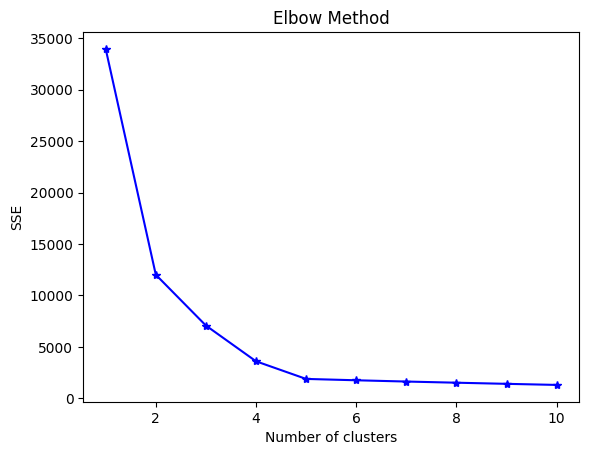

In [156]:
# Find the optimal number of clusters (i.e. K) using elbow method
sse = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, n_init=20, random_state=1)
    kmeans.fit(X_scaled_MinMax)
    sse.append(kmeans.inertia_)
plt.plot(range(1, 11), sse, 'b-*')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [157]:
kmeans = KMeans(n_clusters=5, n_init=20, max_iter=300, random_state=1)

kmeans.fit(X_scaled_MinMax)

kmeans.inertia_

1878.789095683552

RECENCY


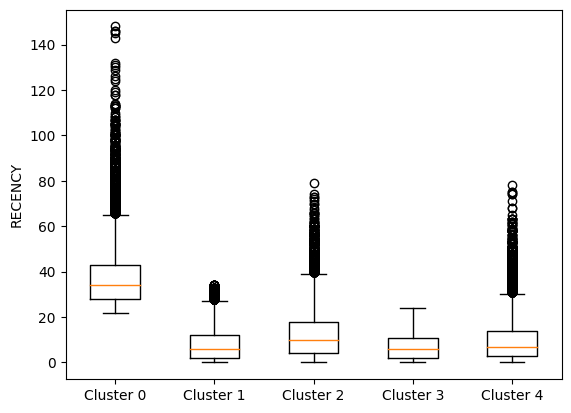

FREQUENCY


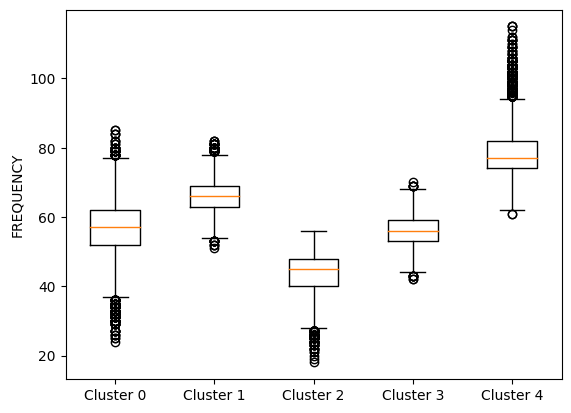

MONETARY


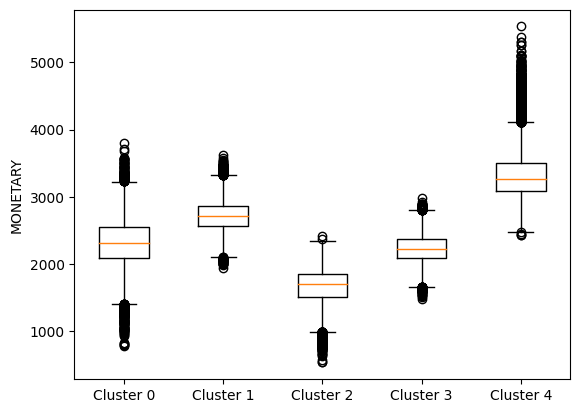

In [158]:
y_pred = kmeans.fit_predict(X_scaled_MinMax)

X['Cluster']=y_pred

i=0
for col in X.drop('Cluster',axis=1): 
    print(col) 
    plt.cla()
    plt.boxplot([X.iloc[:,i][X.Cluster==0].tolist(),
                 X.iloc[:,i][X.Cluster==1].tolist(),
                 X.iloc[:,i][X.Cluster==2].tolist(),
                 X.iloc[:,i][X.Cluster==3].tolist(),
                X.iloc[:,i][X.Cluster==4].tolist()],
                 labels=('Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4'))    
    plt.ylabel(col)
    plt.show()
    i=i+1

Write Description

## 1.1 Members in Country

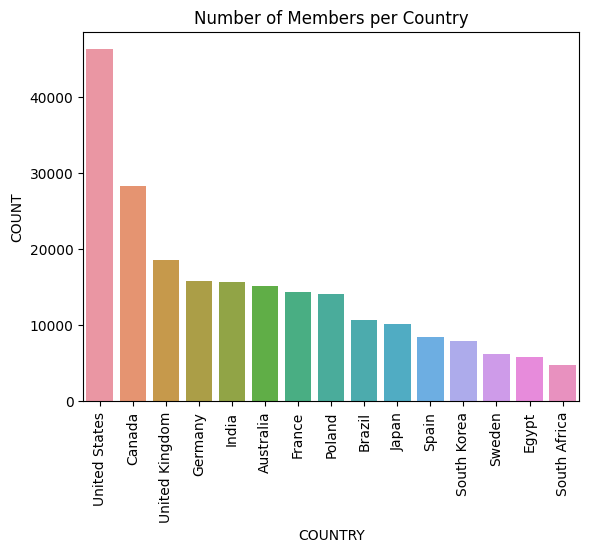

In [159]:
# Unique members
temp_df=tasty_bytes_customer_loyalty.group_by(F.col('Country')).count().to_pandas().sort_values(by='COUNT',ascending=False)
sns.barplot(x='COUNTRY',y='COUNT',data=temp_df)
plt.xticks(rotation=90)
plt.title('Number of Members per Country')
plt.show()

## 1.2 Total number of Transactions

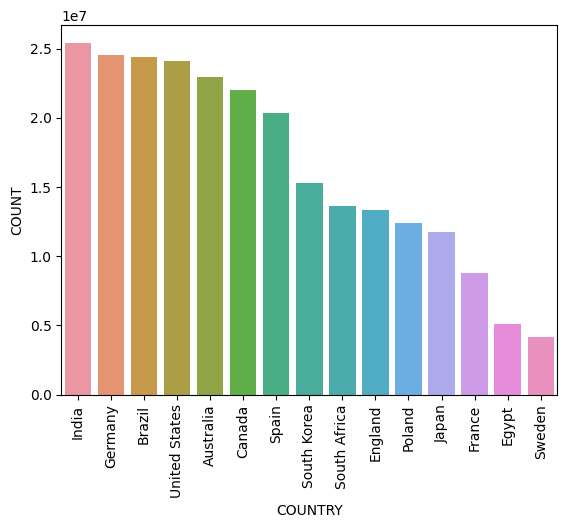

In [160]:
# Number of unique transactions
temp_df=tasty_bytes_orders_v.group_by(F.col('COUNTRY')).agg(F.countDistinct('ORDER_ID').alias('COUNT')).to_pandas().sort_values(by='COUNT',ascending=False)
sns.barplot(x='COUNTRY',y='COUNT',data=temp_df)
plt.xticks(rotation=90)
plt.title('')
plt.show()

## 1.3 Churn Rate by Country

### 1.3.1 Get Churn Cut Off date by Country

In [161]:
#Get last transaction date for each country
last_tran_country = tasty_bytes_orders_v.group_by(F.col('COUNTRY')).max(F.to_date(F.col('ORDER_TS'))).to_pandas()

#Get assumed churned date which is two weeks before last transaction date, then get total number of customers in the assumed time period
last_tran_country['CHURN_DATE']=last_tran_country['MAX(TO_DATE(ORDER_TS))']-datetime.timedelta(days=14)
last_tran_country['CUSTOMER_COUNT_DATE']=last_tran_country['MAX(TO_DATE(ORDER_TS))']-datetime.timedelta(days=44)

#Make pandas dataframe into a snowpark dataframe
last_tran_country_sdf=session.createDataFrame(last_tran_country)

#Merge 
last_tran_country_sdf_join = last_tran_country_sdf.join(
    right=tasty_bytes_orders_v,
    on="COUNTRY",
    how="inner"
)

### 1.3.2 Calculate Churn Rate by Country

In [162]:
#Filter dataframe to the assumed time period
df = last_tran_country_sdf_join[last_tran_country_sdf_join["DATE"] > last_tran_country_sdf_join["CUSTOMER_COUNT_DATE"]]

#Filter to get churned members dataset
df2 = df[last_tran_country_sdf_join["DATE"] > last_tran_country_sdf_join["CHURN_DATE"]]

#Number of customers before churn date
cust_bef = df.groupBy("COUNTRY").agg(F.countDistinct(F.col("CUSTOMER_ID")).alias('COUNT_BEF'))
#Number of customers after churn date
cust_aft = df2.groupBy("COUNTRY").agg(F.countDistinct(F.col("CUSTOMER_ID")).alias('COUNT_AFT'))

#Merge
calculator = cust_aft.join(
    right=cust_bef,
    on="COUNTRY",
    how="inner"
)
calc = calculator.to_pandas()

#Calculate Churn rate 
calc["CHURN_RATE"] = (((calc["COUNT_BEF"] - calc["COUNT_AFT"]) / calc["COUNT_BEF"]) * 100)
temp_df=calc.sort_values(by='CHURN_RATE',ascending=False)

### 1.3.3 Visualise Churn Rate

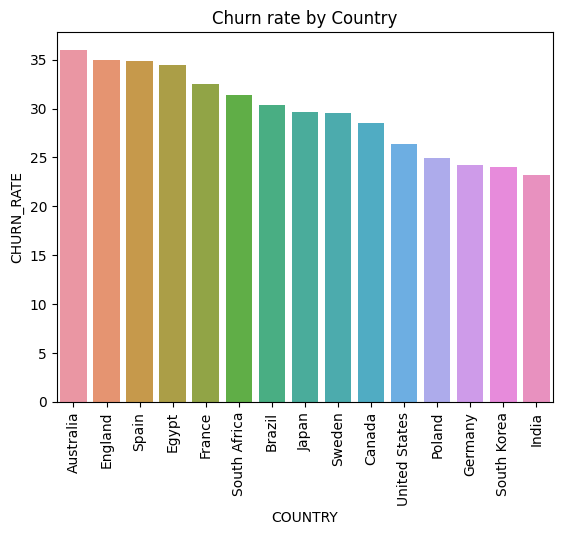

In [163]:
#Churn rate by Country
sns.barplot(x='COUNTRY',y='CHURN_RATE',data=temp_df)
plt.xticks(rotation=90)
plt.title('Churn rate by Country')
plt.show()

<b>We decided to work on United States as it has the most number of customers, a high number of customers and quite a high Churn Rate.

# 3. Data Engineering

## 3.1 Generate new Columns

### 3.1.1 Get Latest Order Date

In [13]:
# called `orders` with columns `customer_id` and `order_ts`
window_spec = Window.partitionBy('customer_id').orderBy(F.col('order_ts').desc())

orders_with_rank = remove_dup.withColumn('rank', F.rank().over(window_spec))

#Get max order of each customer
max_order_ts = orders_with_rank.filter(F.col('rank') == 1).select('customer_id', 'order_ts')

In [14]:
#Rename columns
max_order_ts = max_order_ts.withColumnRenamed('ORDER_TS','Max_Order_TS')

In [15]:
#Merge with second max order dataframe
temp_df=remove_dup.join(right=max_order_ts,on='CUSTOMER_ID',how='inner')

#Filter out last purchase
filtered_df = temp_df.filter(F.col('ORDER_TS') < F.col('Max_Order_TS'))

In [16]:
#Display last recorded purchase globally
tasty_bytes_orders_v.select(F.max('ORDER_TS')).show()

-----------------------
|"MAX(""ORDER_TS"")"  |
-----------------------
|2022-11-01 22:59:59  |
-----------------------



### 3.1.2 RFM (Recency, Freqency, Monetary)

In [112]:
#Get last purchase date as a variable
lastdate=tasty_bytes_orders_v.select(F.max('ORDER_TS')).first()[0]

# Recency
recency = filtered_df.groupBy('CUSTOMER_ID').agg(F.max('ORDER_TS').alias('ORDER_TS'))
recency = recency.withColumn('RECENCY', F.datediff(col1=F.col('ORDER_TS'), col2=F.lit(lastdate),part='day'))

# Frequency
frequency = filtered_df.groupBy('CUSTOMER_ID').agg(F.countDistinct('ORDER_ID').alias('frequency'))

# Monetary
monetary = filtered_df.groupBy('CUSTOMER_ID').agg(F.sum('ORDER_TOTAL').alias('monetary'))

# Merge into RFM table
RFM_table = recency.join(frequency, on='CUSTOMER_ID', how='inner')
RFM_table = RFM_table.join(monetary, on='CUSTOMER_ID', how='inner')

### 3.1.3 Average Time Difference, Max and Min Days without Purchase

In [18]:
# Define a window partitioned by customer and menu item, ordered by date
window_spec = Window.partitionBy("CUSTOMER_ID").orderBy("DATE")

# Add a column with the date of the prior order for each customer and menu item
orders_df = filtered_df.withColumn("DAYS_SINCE_PRIOR_ORDER", F.lag("DATE").over(window_spec))

# Calculate the number of days between the prior order and the current order for each customer and menu item
orders_df = orders_df.withColumn("DAYS_SINCE_PRIOR_ORDER", F.datediff(col1="DAYS_SINCE_PRIOR_ORDER", col2="DATE",part='day'))
orders_df = orders_df.na.drop(subset=["DAYS_SINCE_PRIOR_ORDER"])

#Calculate the average purchase time difference for each customer
avg_time_diff=orders_df.group_by('CUSTOMER_ID').agg(F.round(F.avg('DAYS_SINCE_PRIOR_ORDER'),0).alias('Avg_Days_Between_Purchase'))

# Max Days without Purchase
max_days=orders_df.group_by('CUSTOMER_ID').agg(F.max('DAYS_SINCE_PRIOR_ORDER').alias('Max_Days_Without_Purchase'))

# Min Days without Purchase
min_days=orders_df.group_by('CUSTOMER_ID').agg(F.min('DAYS_SINCE_PRIOR_ORDER').alias('Min_Days_Without_Purchase'))

### 3.1.4 Creating Age and getting Customer's Gender, Marital Status and Country

In [19]:
#Get Customer demographic
cust_demo=tasty_bytes_customer_loyalty.select('CUSTOMER_ID','BIRTHDAY_DATE','GENDER','MARITAL_STATUS','COUNTRY')

# get AGE variable
cust_demo = cust_demo.withColumn("AGE", F.datediff('year', F.col("BIRTHDAY_DATE"),F.lit(lastdate)))

cust_demo.show()


--------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"BIRTHDAY_DATE"  |"GENDER"     |"MARITAL_STATUS"  |"COUNTRY"      |"AGE"  |
--------------------------------------------------------------------------------------------
|66             |1982-11-24       |Male         |Married           |Canada         |40     |
|118            |1988-06-13       |Male         |Single            |United States  |34     |
|131            |1984-12-29       |Male         |Single            |Canada         |38     |
|132            |1981-04-30       |Male         |Single            |Canada         |41     |
|171            |1987-08-06       |Male         |Single            |Canada         |35     |
|189            |1984-03-05       |Undisclosed  |Married           |United States  |38     |
|195            |1987-08-17       |Female       |Single            |Canada         |35     |
|204            |1979-06-25       |Male         |Undisclosed       |Un

### 3.1.5 Join Generated Variables

In [113]:
#Merge to get final dataframe
final_df = RFM_table.join(max_order_ts, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(avg_time_diff, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(max_days, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(min_days, on='CUSTOMER_ID', how='inner')
final_df = final_df.join(cust_demo,on='CUSTOMER_ID',how='inner')

### 3.1.6 Days to Next Order

In [114]:
#Convert timestamp to date such that Days to next orders is more accurate
final_df=final_df.with_column('ORDER_TS',F.to_date(F.col('ORDER_TS')))
final_df=final_df.with_column('MAX_ORDER_TS',F.to_date(F.col('MAX_ORDER_TS')))

In [115]:
#Add Days To Next Order
final_df = final_df.withColumn('Days_To_Next_Order', F.datediff(col1=final_df['ORDER_TS'], col2=final_df['MAX_ORDER_TS'],part='day'))

In [116]:
#Get median of Days to next order
final_df.select(F.median('DAYS_TO_NEXT_ORDER')).show()

------------------------------------
|"MEDIAN(""DAYS_TO_NEXT_ORDER"")"  |
------------------------------------
|9.000                             |
------------------------------------



*We'll create a target variable based on whether customers purchase below or above the median number of days since their prior order. 'Not churn' will indicate purchases below the median, while 'Churn' will represent purchases above the median. This helps identify customers for retention strategies and predicts their engagement with our business.

### 3.1.7 Filter to selected Country

In [24]:
#Filter to United States
final_df=final_df.filter(F.col('COUNTRY')=='United States')

In [25]:
#Drop CustomerID
final_df=final_df.drop('CUSTOMER_ID')

In [26]:
#Convert to pandas
final_df=final_df.to_pandas()

## 3.2 Outlier Handling

### 3.2.1 Identify Numericals

In [27]:
num_cols=final_df.select_dtypes(exclude=['object','datetime64[ns]']).columns

### 3.2.2 Visualise Outliers

In [28]:
#Function to explore the distributuion of variables
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    fig=plt.figure(figsize=(12, 4))
    fig.suptitle(variable)
    
    # histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30,kde=True)
    plt.title('Histogram')

    # boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    
    plt.show()

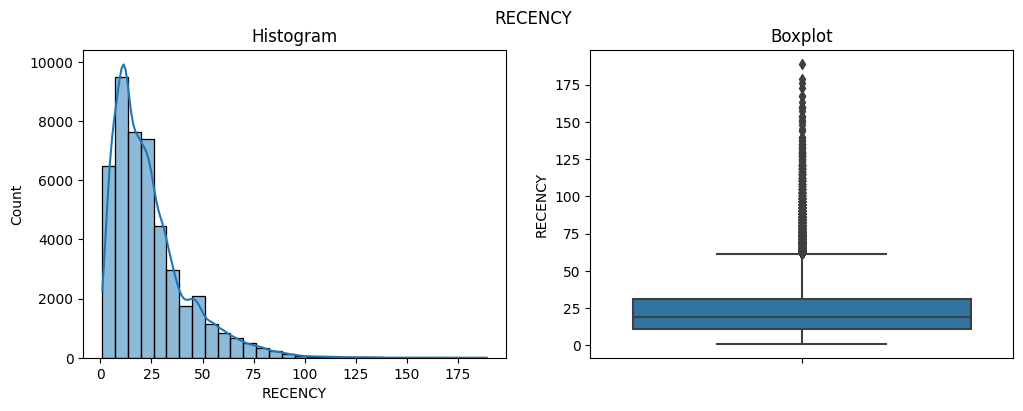

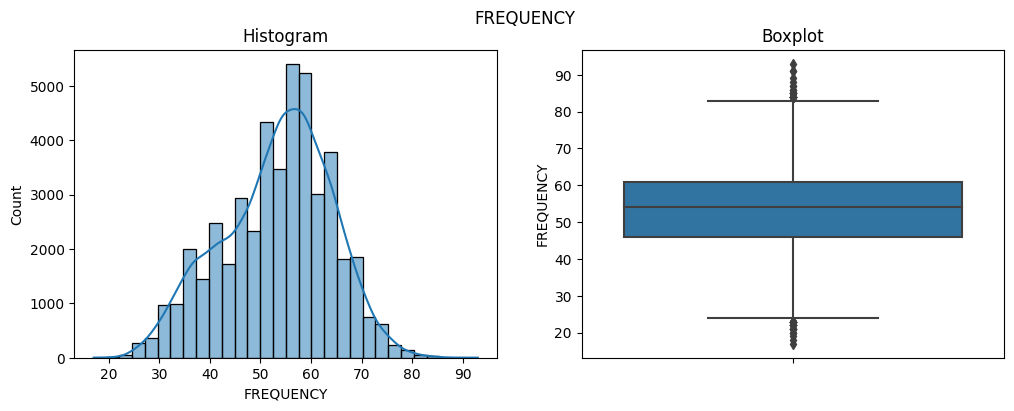

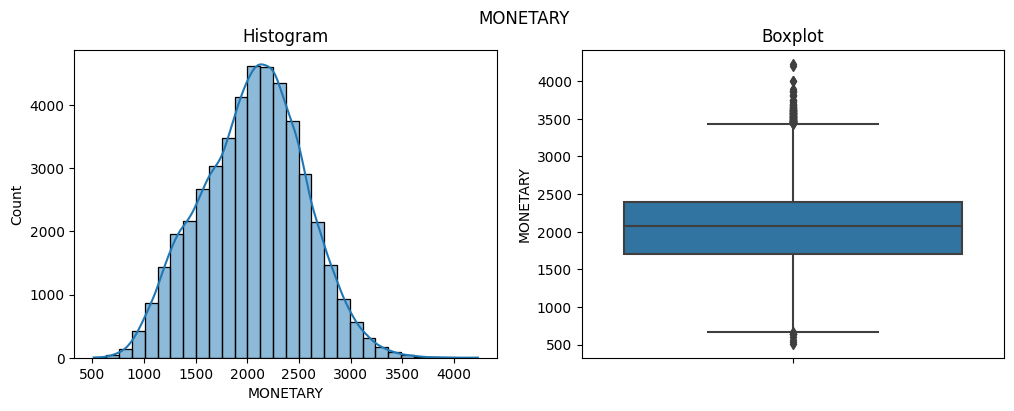

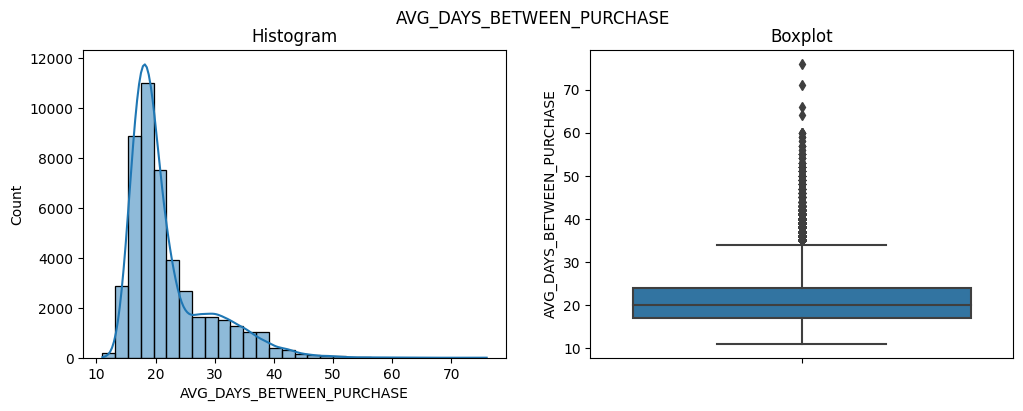

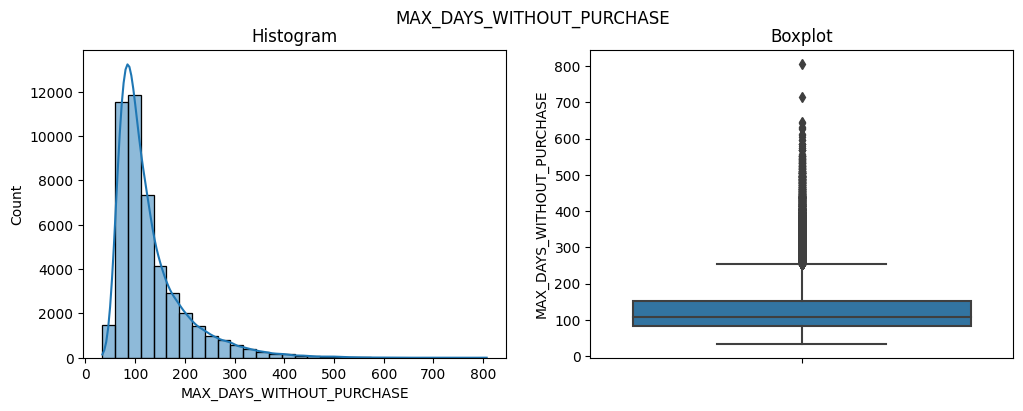

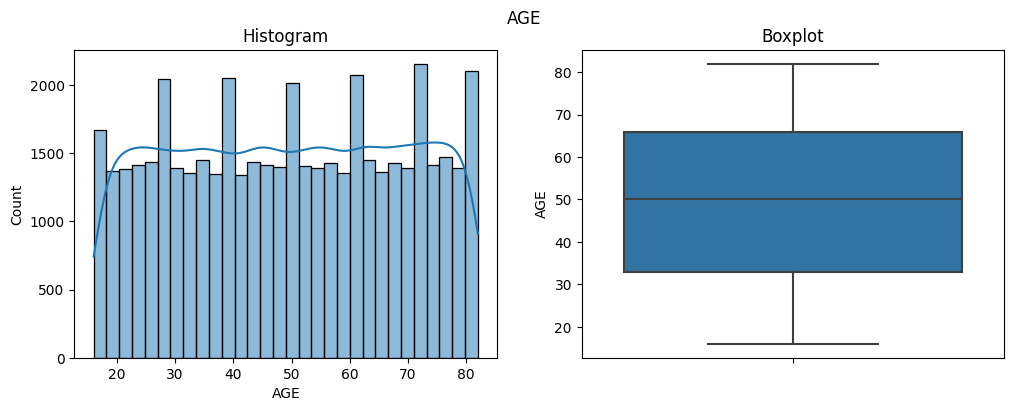

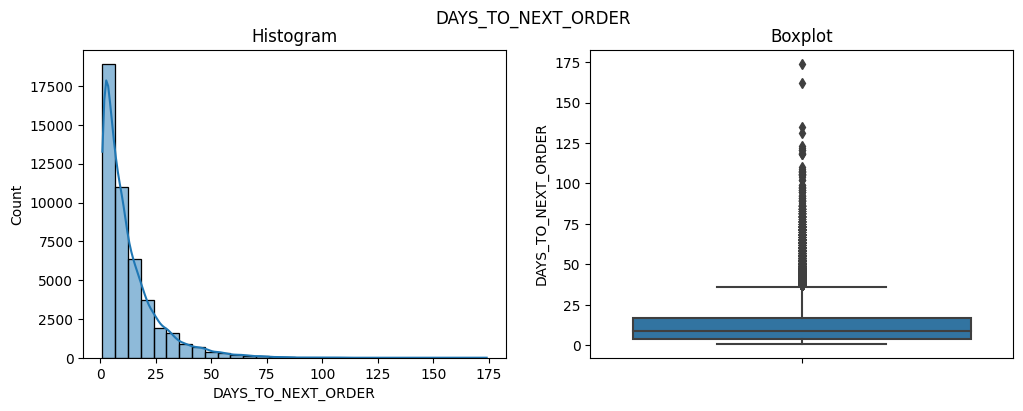

In [29]:
for i in num_cols.drop('MIN_DAYS_WITHOUT_PURCHASE'):
    diagnostic_plots(final_df,i)
    plt.show()

### 3.2.3 Cap the Outliers

#### 3.2.3.1 Cap by IQR

In [30]:
# create the capper
windsorizer = Winsorizer(capping_method='iqr', # choose iqr for skewed or gaussian for normal
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['RECENCY','AVG_DAYS_BETWEEN_PURCHASE','MAX_DAYS_WITHOUT_PURCHASE'])

windsorizer.fit(final_df)


Winsorizer(capping_method='iqr', tail='both',
           variables=['RECENCY', 'AVG_DAYS_BETWEEN_PURCHASE',
                      'MAX_DAYS_WITHOUT_PURCHASE'])

*Note there is no point dealing with outliers in Days to next order as even when dealt with, the 50% mark stays the same, meaning no change to our target variable.

#### 3.2.3.2 Cap by Gaussian

In [31]:
final_df_win = windsorizer.transform(final_df)

In [32]:
# create the capper
windsorizer = Winsorizer(capping_method='gaussian', # choose iqr for skewed or gaussian for normal
                          tail='both', # cap left, right or both tails 
                          fold=3,
                          variables=['FREQUENCY','RECENCY'])

windsorizer.fit(final_df_win)

Winsorizer(tail='both', variables=['FREQUENCY', 'RECENCY'])

In [33]:
final_df_win = windsorizer.transform(final_df_win)

## 3.3 Numerical Transformation

### 3.3.1 Visualise Numericals

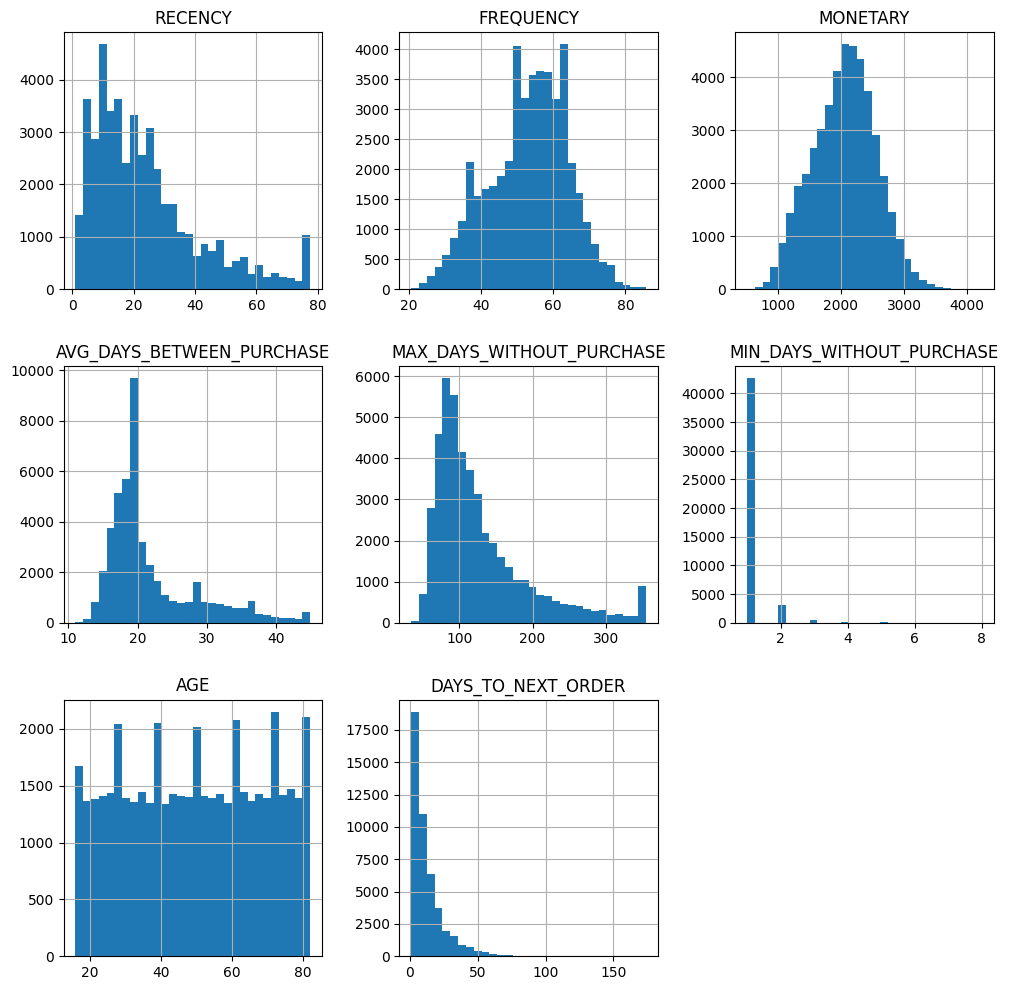

In [34]:
# plot the histogram to inspect variable distributions (not in book)

final_df_win.hist(bins=30, figsize=(12,12))
plt.show()

### 3.3.2 YeoJohnson Transformer

In [35]:
# select variables to transform in a list
cols = ['RECENCY', 'AVG_DAYS_BETWEEN_PURCHASE', 'MAX_DAYS_WITHOUT_PURCHASE', 'MIN_DAYS_WITHOUT_PURCHASE']

# initialize the transformer with a subset of variables to transform
yjt = YeoJohnsonTransformer(variables = cols)

# fit transformer to the dataframe
yjt.fit(final_df_win)

YeoJohnsonTransformer(variables=['RECENCY', 'AVG_DAYS_BETWEEN_PURCHASE',
                                 'MAX_DAYS_WITHOUT_PURCHASE',
                                 'MIN_DAYS_WITHOUT_PURCHASE'])

In [36]:
# transform indicated variables
final_df_yjt = yjt.transform(final_df_win)

## 3.4 Generate Target Variable

In [37]:
#Describe the target
final_df_yjt['DAYS_TO_NEXT_ORDER'].describe()

count    46300.000000
mean        12.572959
std         12.840417
min          1.000000
25%          4.000000
50%          9.000000
75%         17.000000
max        174.000000
Name: DAYS_TO_NEXT_ORDER, dtype: float64

In [38]:
#Add Target Variable Next Purchase Day Range 
final_df_yjt['CHURNED'] = 1
final_df_yjt.loc[final_df_yjt['DAYS_TO_NEXT_ORDER']<=9,'CHURNED'] = 0

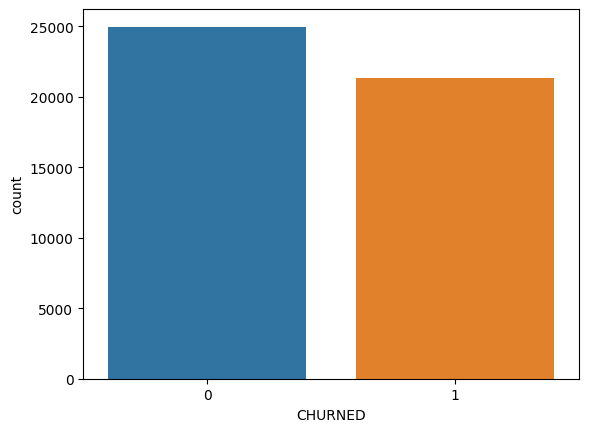

In [39]:
#Distribution of target variable
sns.countplot(data=final_df_yjt,x='CHURNED')
plt.show()

## 3.5 Sample the Data

### 3.5.1 Stratified Sampling

In [40]:
df1=final_df_yjt[final_df_yjt['CHURNED']==1]
len(df1)

21328

In [41]:
df0=final_df_yjt[final_df_yjt['CHURNED']==0]
len(df0)

24972

In [42]:
#Perform Stratified Sampling
df0_sampled = df0.sample(n=len(df1), random_state=4).copy()
df_new=pd.concat([df1,df0_sampled],axis=0)
df_new['CHURNED'].value_counts()

1    21328
0    21328
Name: CHURNED, dtype: int64

# 4 Split the Data

In [43]:
#Train test split
X = df_new.drop(['DAYS_TO_NEXT_ORDER','MAX_ORDER_TS','ORDER_TS','COUNTRY','BIRTHDAY_DATE'], axis =1,
                  errors='ignore')
y = df_new["CHURNED"]


X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.6,random_state=4)

In [44]:
#Test and holdout split
X_test,X_holdout,y_test,y_holdout=train_test_split(X_test,y_test,test_size=0.5,random_state=4)

## 4.1 Data Engineering 2

Data engineering needs to be done in 2 parts, one before and one after splitting the data so as to prevent data leakage to the test datasets

### 4.1.1 Categorical Encoding

#### 4.1.1.1 One Hot Encoding

In [45]:
#One Hot Encoding 
ohe_enc = OneHotEncoder(
     top_categories=None,
     drop_last=True,
     variables=['GENDER','MARITAL_STATUS']) 

ohe_enc.fit(X_train)
X_train = ohe_enc.transform(X_train)
X_test=ohe_enc.transform(X_test)
X_holdout=ohe_enc.transform(X_holdout)

#### 4.1.1.2 Clean the Encoded Columns

In [46]:
X_train.rename({'MARITAL_STATUS_Divorced/Seperated':'MARITAL_STATUS_Divorced_Or_Seperated'}, axis=1,inplace=True)
X_test.rename({'MARITAL_STATUS_Divorced/Seperated':'MARITAL_STATUS_Divorced_Or_Seperated'}, axis=1,inplace=True)
X_holdout.rename({'MARITAL_STATUS_Divorced/Seperated':'MARITAL_STATUS_Divorced_Or_Seperated'}, axis=1,inplace=True)

In [47]:
X_train.columns = map(str.upper, X_train.columns)
X_test.columns = map(str.upper, X_test.columns)
X_holdout.columns = map(str.upper, X_holdout.columns)

### 4.1.2 Feature Scaling

#### 4.1.2.1 Min Max Scaler

In [48]:
#Min Max Scaler

cols_to_scale=X_train.drop('CHURNED',axis=1, errors='ignore').columns

scaler = MinMaxScaler()

#fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train[cols_to_scale])

#transform train and test sets
X_train[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_test[cols_to_scale]= scaler.transform(X_test[cols_to_scale])
X_holdout[cols_to_scale]=scaler.transform(X_holdout[cols_to_scale])

In [49]:
#Save tables to snowflake
session.create_dataframe(X_train).write.save_as_table(table_name="train_table", mode='overwrite')
session.create_dataframe(X_test).write.save_as_table(table_name="test_table", mode='overwrite')
session.create_dataframe(X_holdout).write.save_as_table(table_name="holdout_table", mode='overwrite')

### 4.1.3 Drop Target Variable

In [50]:
X_train=X_train.drop('CHURNED',axis=1, errors='ignore')
X_test=X_test.drop('CHURNED',axis=1, errors='ignore')
X_holdout=X_holdout.drop('CHURNED',axis=1, errors='ignore')

# 5. Model Building

## 5.1 Define Evaluation Function

In [51]:
#Function to show MSE, MAE, r-sq of Classification models
def evaluateModel(model):
    #Accuracy
    print('Train Accuracy:',model.score(X_train, y_train),
          '\nTest Accuracy:',model.score(X_test, y_test),
          '\nHoldout Accuracy:',model.score(X_holdout, y_holdout))

In [52]:
#Function to show MSE, MAE, r-sq of Classification models
def evaluateModelWithName(model,model_name):
    print(model_name)
    print('Train Accuracy:',model.score(X_train, y_train),
          '\nTest Accuracy:',model.score(X_test, y_test),
          '\nHoldout Accuracy:',model.score(X_holdout, y_holdout),
          '\n')

## 5.2 Logistic Regression

### 5.2.1 Build the model

In [53]:
#Build Logistic Regression Model
log_ref_before = LogisticRegression(max_iter=10000)
log_ref_before.fit(X_train, y_train)

evaluateModel(log_ref_before)

Train Accuracy: 0.7681397257062478 
Test Accuracy: 0.7687739313901696 
Holdout Accuracy: 0.7713526607798703


### 5.2.2 Improve the model

In [54]:
# Task 1: Use GridSearch to find the best combination of model hyperparameters

logreg = LogisticRegression()
param_grid = {"penalty": ["l2"],
                "C" : [0.1, 1, 10],
                "solver" : ["newton-cg", "lbfgs", "liblinear"]}

gs =GridSearchCV(logreg, param_grid = param_grid, scoring = "accuracy", cv = 10, n_jobs = -1)
gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.7679632037174012
{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


In [55]:
#Build Logistic Regression Model
log_ref_improved = LogisticRegression(**gs.best_params_)
log_ref_improved.fit(X_train, y_train)

evaluateModel(log_ref_improved)

Train Accuracy: 0.7681397257062478 
Test Accuracy: 0.7691646479643667 
Holdout Accuracy: 0.7713526607798703


## 5.3 Decision Tree

### 5.3.1 Build the model

In [56]:
#Build Decision Tree Model
decision_tree_before = tree.DecisionTreeClassifier(max_depth = 20)

decision_tree_before.fit(X_train, y_train)

evaluateModel(decision_tree_before)

Train Accuracy: 0.9479545188137382 
Test Accuracy: 0.7036805501289365 
Holdout Accuracy: 0.708291005704462


### 5.3.2 Improve the model

In [57]:
dt = tree.DecisionTreeClassifier(max_depth = 2)

param_grid = { "criterion" : ["gini", "entropy"], 
              "min_samples_leaf" : [1, 5, 10,20,30,40,50,100], 
              "min_samples_split" : [2, 4, 10, 12, 16], 
              'max_depth' : [2,3,4,5,6,7]}

gs = GridSearchCV(dt, param_grid=param_grid, scoring='accuracy', cv= 10, n_jobs=-1)
# cv: number of partitions for cross validation
# n_jobs: number of jobs to run in parallel, -1 means using all processors

gs = gs.fit(X_train, y_train) 

print(gs.best_score_)
print(gs.best_params_)

0.7766965003766988
{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [58]:
# Create Decision Tree using the best hyperparameters
decision_tree_improved = tree.DecisionTreeClassifier(**gs.best_params_)
decision_tree_improved.fit(X_train, y_train)

evaluateModel(decision_tree_improved)

Train Accuracy: 0.7766967530184035 
Test Accuracy: 0.7762756896147535 
Holdout Accuracy: 0.7733062436508557


## 5.4 Random Forest

### 5.4.1 Build the model

In [59]:
#Build Random Forest Model

random_forest_before= RandomForestClassifier(n_estimators=100)
random_forest_before.fit(X_train, y_train)

evaluateModel(random_forest_before)

Train Accuracy: 1.0 
Test Accuracy: 0.7705712276314761 
Holdout Accuracy: 0.768461358130812


### 5.4.2 Improve the model

In [60]:
rf = RandomForestClassifier()
param_grid = {'n_estimators': [10, 50, 100],
'max_depth': [ 4, 6, 8, 10],
'min_samples_split': [5, 10, 15, 20]}

gs = GridSearchCV(rf, param_grid = param_grid, scoring = "accuracy", cv = 10, n_jobs = -1)
gs = gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.7772825638310221
{'max_depth': 6, 'min_samples_split': 20, 'n_estimators': 50}


In [61]:
# Build RandomForest Model and Evaluate both training and testing accuracy
random_forest_improved = RandomForestClassifier(**gs.best_params_)
random_forest_improved.fit(X_train,y_train)

evaluateModel(random_forest_improved)

Train Accuracy: 0.7779275583167272 
Test Accuracy: 0.7763538329295929 
Holdout Accuracy: 0.7740876767992498


## 5.5 Adaboost

### 5.5.1 Build the model

In [62]:
#Build Ada Boost Model
adb_before = AdaBoostClassifier(DecisionTreeClassifier(),n_estimators=5,learning_rate=1)
adb_before.fit(X_train, y_train)

evaluateModel(adb_before)

Train Accuracy: 1.0 
Test Accuracy: 0.6877393139016957 
Holdout Accuracy: 0.6922716261623818


### 5.5.2 Improve the model

In [63]:
adb = AdaBoostClassifier()

param_grid = {
    'estimator': [tree.DecisionTreeClassifier(max_depth=1), tree.DecisionTreeClassifier(max_depth=2)],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1],
    'algorithm': ['SAMME', 'SAMME.R']
}

gs = GridSearchCV(adb, param_grid, cv=5, n_jobs=-1)

gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.7766968514633896
{'algorithm': 'SAMME.R', 'estimator': DecisionTreeClassifier(max_depth=1), 'learning_rate': 0.5, 'n_estimators': 50}


In [64]:
#Build Ada Boost Model and Evaluate both training and testing accuracy
adb_improved = AdaBoostClassifier(**gs.best_params_)
adb_improved.fit(X_train,y_train)

evaluateModel(adb_improved)

Train Accuracy: 0.777458680107842 
Test Accuracy: 0.7760412596702352 
Holdout Accuracy: 0.7736969602250527


## 5.6 XGboost (Final Model)

### 5.6.1 Build the model

In [65]:
#Build XGBoost Model
xgb_before = XGBClassifier(n_estimators = 20, learning_rate = 0.1, eval_metric='logloss',max_depth = 20)
xgb_before.fit(X_train, y_train)

#Evaluate XGBoost Model
evaluateModel(xgb_before)

Train Accuracy: 0.9585628882897668 
Test Accuracy: 0.7537704149410018 
Holdout Accuracy: 0.7558021411268266


### 5.6.2 Improve the model

In [66]:
xgb = XGBClassifier()

param_grid = {
    'max_depth': [4, 6, 8], 
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [20, 50, 100],
    'colsample_bytree': [0.6,0.7,0.8],
    'subsample':[0.6,0.7,0.8]
}

gs = GridSearchCV(xgb, param_grid, cv=5, n_jobs=-1)

gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

0.7771656472442275
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 20, 'subsample': 0.7}


In [67]:
#  Build XGBoost Model and Evaluate both training and testing accuracy 
xgb_improved = XGBClassifier(colsample_bytree= 0.8, learning_rate= 0.05, max_depth= 4, n_estimators= 20, subsample= 0.7)
xgb_improved.fit(X_train,y_train)

evaluateModel(xgb_improved)

Train Accuracy: 0.7805649982417067 
Test Accuracy: 0.7750253965773228 
Holdout Accuracy: 0.7744002500586075


In [68]:
#Classification Report
print(classification_report(y_test,xgb_improved.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.67      0.75      6291
           1       0.73      0.88      0.80      6506

    accuracy                           0.78     12797
   macro avg       0.79      0.77      0.77     12797
weighted avg       0.79      0.78      0.77     12797



# 6. Evaulation

## 6.1 Model Accuracies

In [69]:
evaluateModelWithName(log_ref_improved,'log_ref_improved')

evaluateModelWithName(decision_tree_improved,'decision_tree_improved')

evaluateModelWithName(random_forest_improved,'rdm_fst_improved')

evaluateModelWithName(adb_improved,'adb_improved')

evaluateModelWithName(xgb_improved,'xgb_improved')

log_ref_improved
Train Accuracy: 0.7681397257062478 
Test Accuracy: 0.7691646479643667 
Holdout Accuracy: 0.7713526607798703 

decision_tree_improved
Train Accuracy: 0.7766967530184035 
Test Accuracy: 0.7762756896147535 
Holdout Accuracy: 0.7733062436508557 

rdm_fst_improved
Train Accuracy: 0.7779275583167272 
Test Accuracy: 0.7763538329295929 
Holdout Accuracy: 0.7740876767992498 

adb_improved
Train Accuracy: 0.777458680107842 
Test Accuracy: 0.7760412596702352 
Holdout Accuracy: 0.7736969602250527 

xgb_improved
Train Accuracy: 0.7805649982417067 
Test Accuracy: 0.7750253965773228 
Holdout Accuracy: 0.7744002500586075 



# 7 Snowflake 

## 7.1 Create the Stage 

In [70]:
# Create stage
session.sql("CREATE STAGE IF NOT EXISTS model_stage").collect()

[Row(status='MODEL_STAGE already exists, statement succeeded.')]

## 7.2 Create Tables

In [71]:
train_table = session.table(name="train_table")
test_table=session.table(name="test_table")

## 7.3 Create Final Model 

### 7.3.1 Create Model Training Procedure

Define your Stored Procedure to train an XGBoost Model

In [72]:
# This local Python-function will be registered as a Stored Procedure and runs in Snowflake
def sproc_train_xgboost_model(session: Session, 
                              training_table: str, 
                              feature_cols: list,
                              target_col: str,
                              model_name: str) -> T.Variant:
    from joblib import dump
    import os
    # Loading data into pandas dataframe
    local_training_data = session.table(training_table).to_pandas()

    # Define features and label
    X = local_training_data[feature_cols]
    y = local_training_data[target_col]

    # Actual model training
    from xgboost import XGBClassifier
    xgbmodel = XGBClassifier(colsample_bytree= 0.8, learning_rate= 0.05, max_depth= 4, n_estimators= 20, subsample= 0.7)
    xgbmodel.fit(X,y)
    
    # Getting model coefficients
    feat_importance = pd.DataFrame(xgbmodel.feature_importances_,feature_cols,columns=['FeatImportance']).to_dict()

    # Save model as file and upload to Snowflake stage
    model_file = os.path.join('/tmp', model_name)
    dump(xgbmodel, model_file)
    session.file.put(model_file, '@MODEL_STAGE', auto_compress=False, overwrite=True)

    return feat_importance

### 7.3.2 Register Model Training Procedure 

Register your Stored Procedure to train an XGBoost Model

In [73]:
# Registering the function as a Stored Procedure
sproc_xgboost_model = session.sproc.register(func=sproc_train_xgboost_model, 
                                            name='sproc_train_xgboost_model', 
                                            is_permanent=True, 
                                            replace=True, 
                                            stage_location='@MODEL_STAGE', 
                                            packages=[f'snowflake-snowpark-python==1.3.0'
                                                      ,f'scikit-learn==1.2.2'
                                                      ,f'xgboost==1.7.3'
                                                      ,f'joblib==1.1.1'])

The version of package xgboost in the local environment is 1.7.5, which does not fit the criteria for the requirement xgboost==1.7.3. Your UDF might not work when the package version is different between the server and your local environment
The version of package joblib in the local environment is 1.2.0, which does not fit the criteria for the requirement joblib==1.1.1. Your UDF might not work when the package version is different between the server and your local environment


### 7.3.2 Run Model Training Procedure 

Run your Stored Procedure to train an XGBoost Model

In [74]:
training_table = "frostbyte_tasty_bytes.analytics.train_table"
# get feature columns
feature_cols = train_table.drop('Churned').columns
target_col = 'CHURNED'
model_name = 'xgboost_model.sav'

feature_importance = sproc_xgboost_model(training_table, 
                                         feature_cols, 
                                         target_col,
                                         model_name, 
                                         session=session)

feature_importance = pd.DataFrame(eval(feature_importance))

In [75]:
# The model is now stored in a Snowflake stage
pd.DataFrame(session.sql('LIST @MODEL_STAGE').collect())

,name,size,md5,last_modified
0,model_stage/c63fd01776483bfda20e4ab09ae5ed4643...,13616,d9c1820c27993d4d292aed8f961da0d2,"Wed, 24 May 2023 16:24:06 GMT"
1,model_stage/e1c68012a174d85e8c6c4470c9cb5ff0e5...,353920,74ac8c781a7eeca2f0aecda85089026d,"Wed, 24 May 2023 16:24:05 GMT"
2,model_stage/optuna_model.sav,27472,de4c7c5c4363049dc23d3a3f6ee24f30,"Wed, 24 May 2023 16:25:33 GMT"
3,model_stage/xgb_churn_model.sav,36528,1a05a2eefcaccff7b8f7d6f9a016fb40,"Tue, 23 May 2023 15:04:42 GMT"
4,model_stage/xgboost_model.sav,39056,535b96b75f612f3d95eea760fa5fa8f8,"Fri, 26 May 2023 12:45:33 GMT"


In [76]:
#View Feature Importance
feature_importance.sort_values('FeatImportance')

,FeatImportance
MARITAL_STATUS_SINGLE,0.004488
MIN_DAYS_WITHOUT_PURCHASE,0.007895
AGE,0.008176
GENDER_MALE,0.010410
MARITAL_STATUS_DIVORCED_OR_SEPERATED,0.013248
MARITAL_STATUS_UNDISCLOSED,0.013936
GENDER_FEMALE,0.013960
MAX_DAYS_WITHOUT_PURCHASE,0.016429
AVG_DAYS_BETWEEN_PURCHASE,0.024120
MONETARY,0.024466


## 7.4 UDF to Score Model

## 7.4.1 Define UDF

In [77]:
# Define a simple scoring function
from cachetools import cached

@cached(cache={})
def load_model(model_path: str) -> object:
    from joblib import load
    model = load(model_path)
    return model

def udf_score_logistic_xgboost_model_vec_cached(df: pd.DataFrame) -> pd.Series:
    import os
    import sys
    # file-dependencies of UDFs are available in snowflake_import_directory
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    model_name = 'xgboost_model.sav'
    model = load_model(import_dir+model_name)
    df.columns = feature_cols
    scored_data = pd.Series(model.predict(df))
    return scored_data

## 7.4.2 Register UDF

Register your UDF to Score an XGBoost Model

In [78]:
# Register UDF
udf_score_logistic_xgboost_model_vec_cached = session.udf.register(func=udf_score_logistic_xgboost_model_vec_cached, 
                                                                   name="udf_score_xgboost_model", 
                                                                   stage_location='@MODEL_STAGE',
                                                                   input_types=[T.FloatType()]*len(feature_cols),
                                                                   return_type = T.FloatType(),
                                                                   replace=True, 
                                                                   is_permanent=True, 
                                                                   imports=['@MODEL_STAGE/xgboost_model.sav'],
                                                                   packages=[f'scikit-learn==1.2.2'
                                                                             ,f'xgboost==1.7.3'
                                                                             ,f'joblib==1.1.1'
                                                                             ,f'cachetools==4.2.2'], 
                                                                   session=session)

The version of package xgboost in the local environment is 1.7.5, which does not fit the criteria for the requirement xgboost==1.7.3. Your UDF might not work when the package version is different between the server and your local environment
The version of package joblib in the local environment is 1.2.0, which does not fit the criteria for the requirement joblib==1.1.1. Your UDF might not work when the package version is different between the server and your local environment
The version of package cachetools in the local environment is 5.3.0, which does not fit the criteria for the requirement cachetools==4.2.2. Your UDF might not work when the package version is different between the server and your local environment


## 7.4.2 Run UDF

Run your UDF to Score an XGBoost Model

In [79]:
%%time
# Scoring test data with scalar UDF but caching the model
scored_sdf = test_table.with_column('PREDICTION', udf_score_logistic_xgboost_model_vec_cached(*feature_cols))
scored_sdf.write.save_as_table(table_name='frostbyte_tasty_bytes.analytics.test_table', mode='overwrite')

CPU times: total: 15.6 ms
Wall time: 2.73 s


In [80]:
scored_sdf.select(["Churned","PREDICTION"]).show()

----------------------------
|"CHURNED"  |"PREDICTION"  |
----------------------------
|0          |1.0           |
|1          |1.0           |
|1          |0.0           |
|1          |1.0           |
|0          |0.0           |
|1          |1.0           |
|0          |0.0           |
|1          |1.0           |
|0          |0.0           |
|1          |1.0           |
----------------------------



## Reset

In [81]:
"""# Drop training table
session.sql("DROP TABLE IF EXISTS frostbyte_tasty_bytes.analytics.shift_sales_train").collect()

# Drop testing table
session.sql("DROP TABLE IF EXISTS frostbyte_tasty_bytes.analytics.shift_sales_test").collect()

# Drop training stored procedure
session.sql("DROP PROCEDURE IF EXISTS sproc_train_linreg(varchar, array, varchar, varchar)").collect()

# Drop inference user-defined function
session.sql(
    "DROP FUNCTION IF EXISTS udf_linreg_predict_location_sales(float, float, float, float, float, float, float, float)"
).collect()

# Drop stage
session.sql("DROP STAGE IF EXISTS model_stage").collect()

# Scale down compute
session.sql("ALTER WAREHOUSE tasty_ds_wh SET WAREHOUSE_SIZE = XSMALL").collect()

# Close the session
session.close()"""

'# Drop training table\nsession.sql("DROP TABLE IF EXISTS frostbyte_tasty_bytes.analytics.shift_sales_train").collect()\n\n# Drop testing table\nsession.sql("DROP TABLE IF EXISTS frostbyte_tasty_bytes.analytics.shift_sales_test").collect()\n\n# Drop training stored procedure\nsession.sql("DROP PROCEDURE IF EXISTS sproc_train_linreg(varchar, array, varchar, varchar)").collect()\n\n# Drop inference user-defined function\nsession.sql(\n    "DROP FUNCTION IF EXISTS udf_linreg_predict_location_sales(float, float, float, float, float, float, float, float)"\n).collect()\n\n# Drop stage\nsession.sql("DROP STAGE IF EXISTS model_stage").collect()\n\n# Scale down compute\nsession.sql("ALTER WAREHOUSE tasty_ds_wh SET WAREHOUSE_SIZE = XSMALL").collect()\n\n# Close the session\nsession.close()'